In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

# Transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]
)

training_data = FashionMNIST(root='data', train = True, download = True, transform=transform, )
test_data = FashionMNIST(root='data', train=True, download = True, transform=transform, )

batch_size = 64
train_dataset = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)

classes = ('T-shirt/top', 'Truser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0) # Compress channels to single channel
    img = img / 2 + .5 # Unnormalized
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='gray')
    else:
        plt.imshow(npimg, (1, 2, 0))
#     plt.show()
    return

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = ConvNet()

# Criterion(loss)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

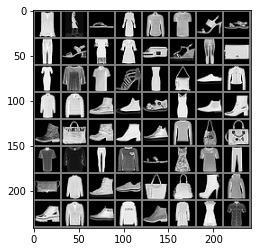

In [33]:
# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Create log_dir
writer = SummaryWriter("runs/fasion_mnist_experiment_1") # Default log_dir = runs

# Write to tensorboard
dataiter = iter(train_dataset)
images, labels = next(dataiter)

# Make grid-images
img_grid = torchvision.utils.make_grid(images)

# Draw grid
matplotlib_imshow(img_grid, one_channel=True)

# Write grid to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)


# Visualize model
writer.add_graph(net, images)
writer.close()


# Run tensorboard
# !tensorboard --logdir=runs

In [34]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Dimension-Reduction Visualization
def select_n_random(data, labels, n=100):
    '''Select random n-data with labels'''
    assert len(data) == len(labels)
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

images, labels = select_n_random(training_data.data, training_data.targets)
class_labels = [classes[lab] for lab in labels]
features = images.view(-1, 28*28)
writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))
writer.close()

# !tensorboard --logdir=runs

In [36]:
# Track model-learning

def images_to_prob(net, images):
    '''Return pred_out, pred_prob'''
    output = net(images)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''Show figures with preds'''
    preds, probs = images_to_prob(net, images)
    fig = plt.figure(figsize=(12,48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100,
            classes[labels[idx]]),
                     color=("green" if preds[idx] == labels[idx].item() else "red")
        )
    return fig

# Record to tensorboard -- add_scalar
running_loss = 0.0
for epoch in range(1):
    for i, data in enumerate(train_dataset):
        if i >= 10:
            break
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 2 == 1: # Every 2 minibatchs
            writer.add_scalar('training loss', running_loss / 2, epoch * 2 + i)
        writer.add_figure('predictions vs. actuals', plot_classes_preds(net, inputs, labels),
                             global_step=epoch * 2 + i)
        running_loss = 0.0
print("Finished Training")

!tensorboard --logdir=runs

Finished Training
W0712 23:19:57.476837 6142029824 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0712 23:19:57.477948 6142029824 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0712 23:19:57.479578 6142029824 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0712 23:19:57.482368 6142029824 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0712 23:19:57.484184 6142

https://bioinformaticsandme.tistory.com/328
https://m.blog.naver.com/sw4r/221681933731

In [39]:
# Evaluate learned model
class_probs = []
class_label = []
with torch.no_grad():
    for data in test_dataset:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        class_probs.append(class_probs_batch)
        class_label.append(labels)
test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]
    writer.add_pr_curve(classes[class_index], tensorboard_truth, tensorboard_probs, global_step=global_step)
    writer.close()
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

In [40]:
!tensorboard --logdir=runs

W0712 23:29:31.942125 6139375616 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0712 23:29:31.943410 6139375616 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0712 23:29:31.945142 6139375616 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0712 23:29:31.947787 6139375616 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0712 23:29:31.949619 6139375616 plugin_even